# Regression Model Comparison using `PyCaret`

In [1]:
# !pip install pycaret # if necessary

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf

# from statsmodels.formula.api import ols
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# !pip install pycaret
from pycaret.regression import *

import seaborn as sns

### 1. Download IONQ data using `yfinance`

In [3]:
stockCode = "IONQ"
# startDate = "2022-07-01"
# endDate = "2023-06-30"

In [4]:
ticker = yf.Ticker(stockCode)
# price_hist = ticker.history(start=startDate, end=endDate)
price_hist = ticker.history(period="max", interval="1d")

price_hist.index = [x.date() for x in price_hist.index]
# date_range = pd.date_range(startDate, endDate)
# price_hist = price_hist.reindex(date_range)
price_hist.shape

(652, 7)

### 2. Add features
- Shift: Price before n days
- MA: Avg. price for last n days
- VolAvg: Avg. vol for last n days

In [5]:
close = price_hist[["Close", "Volume"]].copy()

close["Shift_1"] = close["Close"].shift(1)
close["Shift_5"] = close["Close"].shift(5)
close["Shift_20"] = close["Close"].shift(20)
close["Shift_60"] = close["Close"].shift(60)
close["Shift_120"] = close["Close"].shift(120)
close["Shift_240"] = close["Close"].shift(240)

close["MA_5"] = close["Close"].rolling(5).mean()
close["MA_20"] = close["Close"].rolling(20).mean()
close["MA_60"] = close["Close"].rolling(60).mean()
close["MA_120"] = close["Close"].rolling(120).mean()
close["MA_240"] = close["Close"].rolling(240).mean()

close["Vol_1"] = close["Volume"].shift(1)
close["VolAvg_5"] = close["Volume"].rolling(5).mean()
close["VolAvg_20"] = close["Volume"].rolling(20).mean()
close["VolAvg_60"] = close["Volume"].rolling(60).mean()
close["VolAvg_120"] = close["Volume"].rolling(120).mean()
close["VolAvg_240"] = close["Volume"].rolling(240).mean()

In [6]:
close = close.dropna()
print(close.shape)

(412, 19)


In [7]:
close.head(5)

Close    Volume    Shift_1    Shift_5   Shift_20  Shift_60  \
2021-12-15  17.840000   6809000  16.100000  20.969999  26.379999     10.05   
2021-12-16  16.059999   7132400  17.840000  18.610001  31.000000      9.99   
2021-12-17  16.770000  11570300  16.059999  18.570000  27.959999     10.01   
2021-12-20  15.280000   5446000  16.770000  16.670000  28.010000     11.30   
2021-12-21  16.180000   3845800  15.280000  16.100000  23.180000     11.94   

            Shift_120  Shift_240    MA_5    MA_20      MA_60     MA_120  \
2021-12-15      10.39      10.80  17.558  22.1605  15.928500  13.006167   
2021-12-16      10.49      11.11  17.048  21.4135  16.029667  13.052583   
2021-12-17      10.55      11.05  16.688  20.8540  16.142333  13.104417   
2021-12-20      10.69      11.11  16.410  20.2175  16.208667  13.142667   
2021-12-21      10.70      11.01  16.426  19.8675  16.279333  13.188333   

               MA_240       Vol_1   VolAvg_5  VolAvg_20     VolAvg_60  \
2021-12-15  12.002708   5066300.0  5484760.0  8024910.0  6.950093e+06   
2021-12-16  12.023333   6809000.0  5658380.0  7365160.0  7.011992e+06   
2021-12-17  12.047167   7132400.0  7247060.0  6823755.0  7.136543e+06   
2021-12-20  12.064542  11570300.0  7204800.0  6682255.0  7.012695e+06   
2021-12-21  12.086083   5446000.0  6960700.0  6265540.0  6.910717e+06   

              VolAvg_120    VolAvg_240  
2021-12-15  3.746622e+06  2.182983e+06  
2021-12-16  3.801465e+06  2.212012e+06  
2021-12-17  3.895502e+06  2.259490e+06  
2021-12-20  3.937217e+06  2.281790e+06  
2021-12-21  3.967204e+06  2.297241e+06

In [8]:
close.tail(5)

Close    Volume    Shift_1    Shift_5  Shift_20  Shift_60  \
2023-08-01  19.860001  15524800  19.250000  15.220000     13.50      5.57   
2023-08-02  18.330000  13988200  19.860001  16.190001     14.12      5.90   
2023-08-03  18.290001   7780900  18.330000  15.530000     13.29      6.15   
2023-08-04  17.389999  10830200  18.290001  17.930000     13.28      6.38   
2023-08-07  15.580000  15216490  17.389999  19.250000     14.03      6.95   

            Shift_120  Shift_240    MA_5    MA_20      MA_60    MA_120  \
2023-08-01       5.15       8.38  17.752  15.2575  11.543167  8.460000   
2023-08-02       5.13       7.86  18.180  15.4680  11.750333  8.570000   
2023-08-03       4.69       7.63  18.732  15.7180  11.952667  8.683333   
2023-08-04       4.81       6.62  18.624  15.9235  12.136167  8.788167   
2023-08-07       4.89       6.42  17.890  16.0010  12.280000  8.877250   

              MA_240       Vol_1    VolAvg_5   VolAvg_20     VolAvg_60  \
2023-08-01  6.719333  13950900.0  13164720.0  11035875.0  1.166753e+07   
2023-08-02  6.762958  15524800.0  13958720.0  11041425.0  1.183181e+07   
2023-08-03  6.807375  13988200.0  13212680.0  10921730.0  1.189428e+07   
2023-08-04  6.852250   7780900.0  12415000.0  11046540.0  1.201259e+07   
2023-08-07  6.890417  10830200.0  12668118.0  11336524.5  1.217798e+07   

              VolAvg_120    VolAvg_240  
2023-08-01  7.973620e+06  5.508369e+06  
2023-08-02  8.062512e+06  5.538263e+06  
2023-08-03  8.087948e+06  5.547073e+06  
2023-08-04  8.155308e+06  5.569294e+06  
2023-08-07  8.261096e+06  5.618480e+06

### 3. Visualization

In [9]:
close = close.drop(columns=["Volume"])
print(close.shape)

(412, 18)


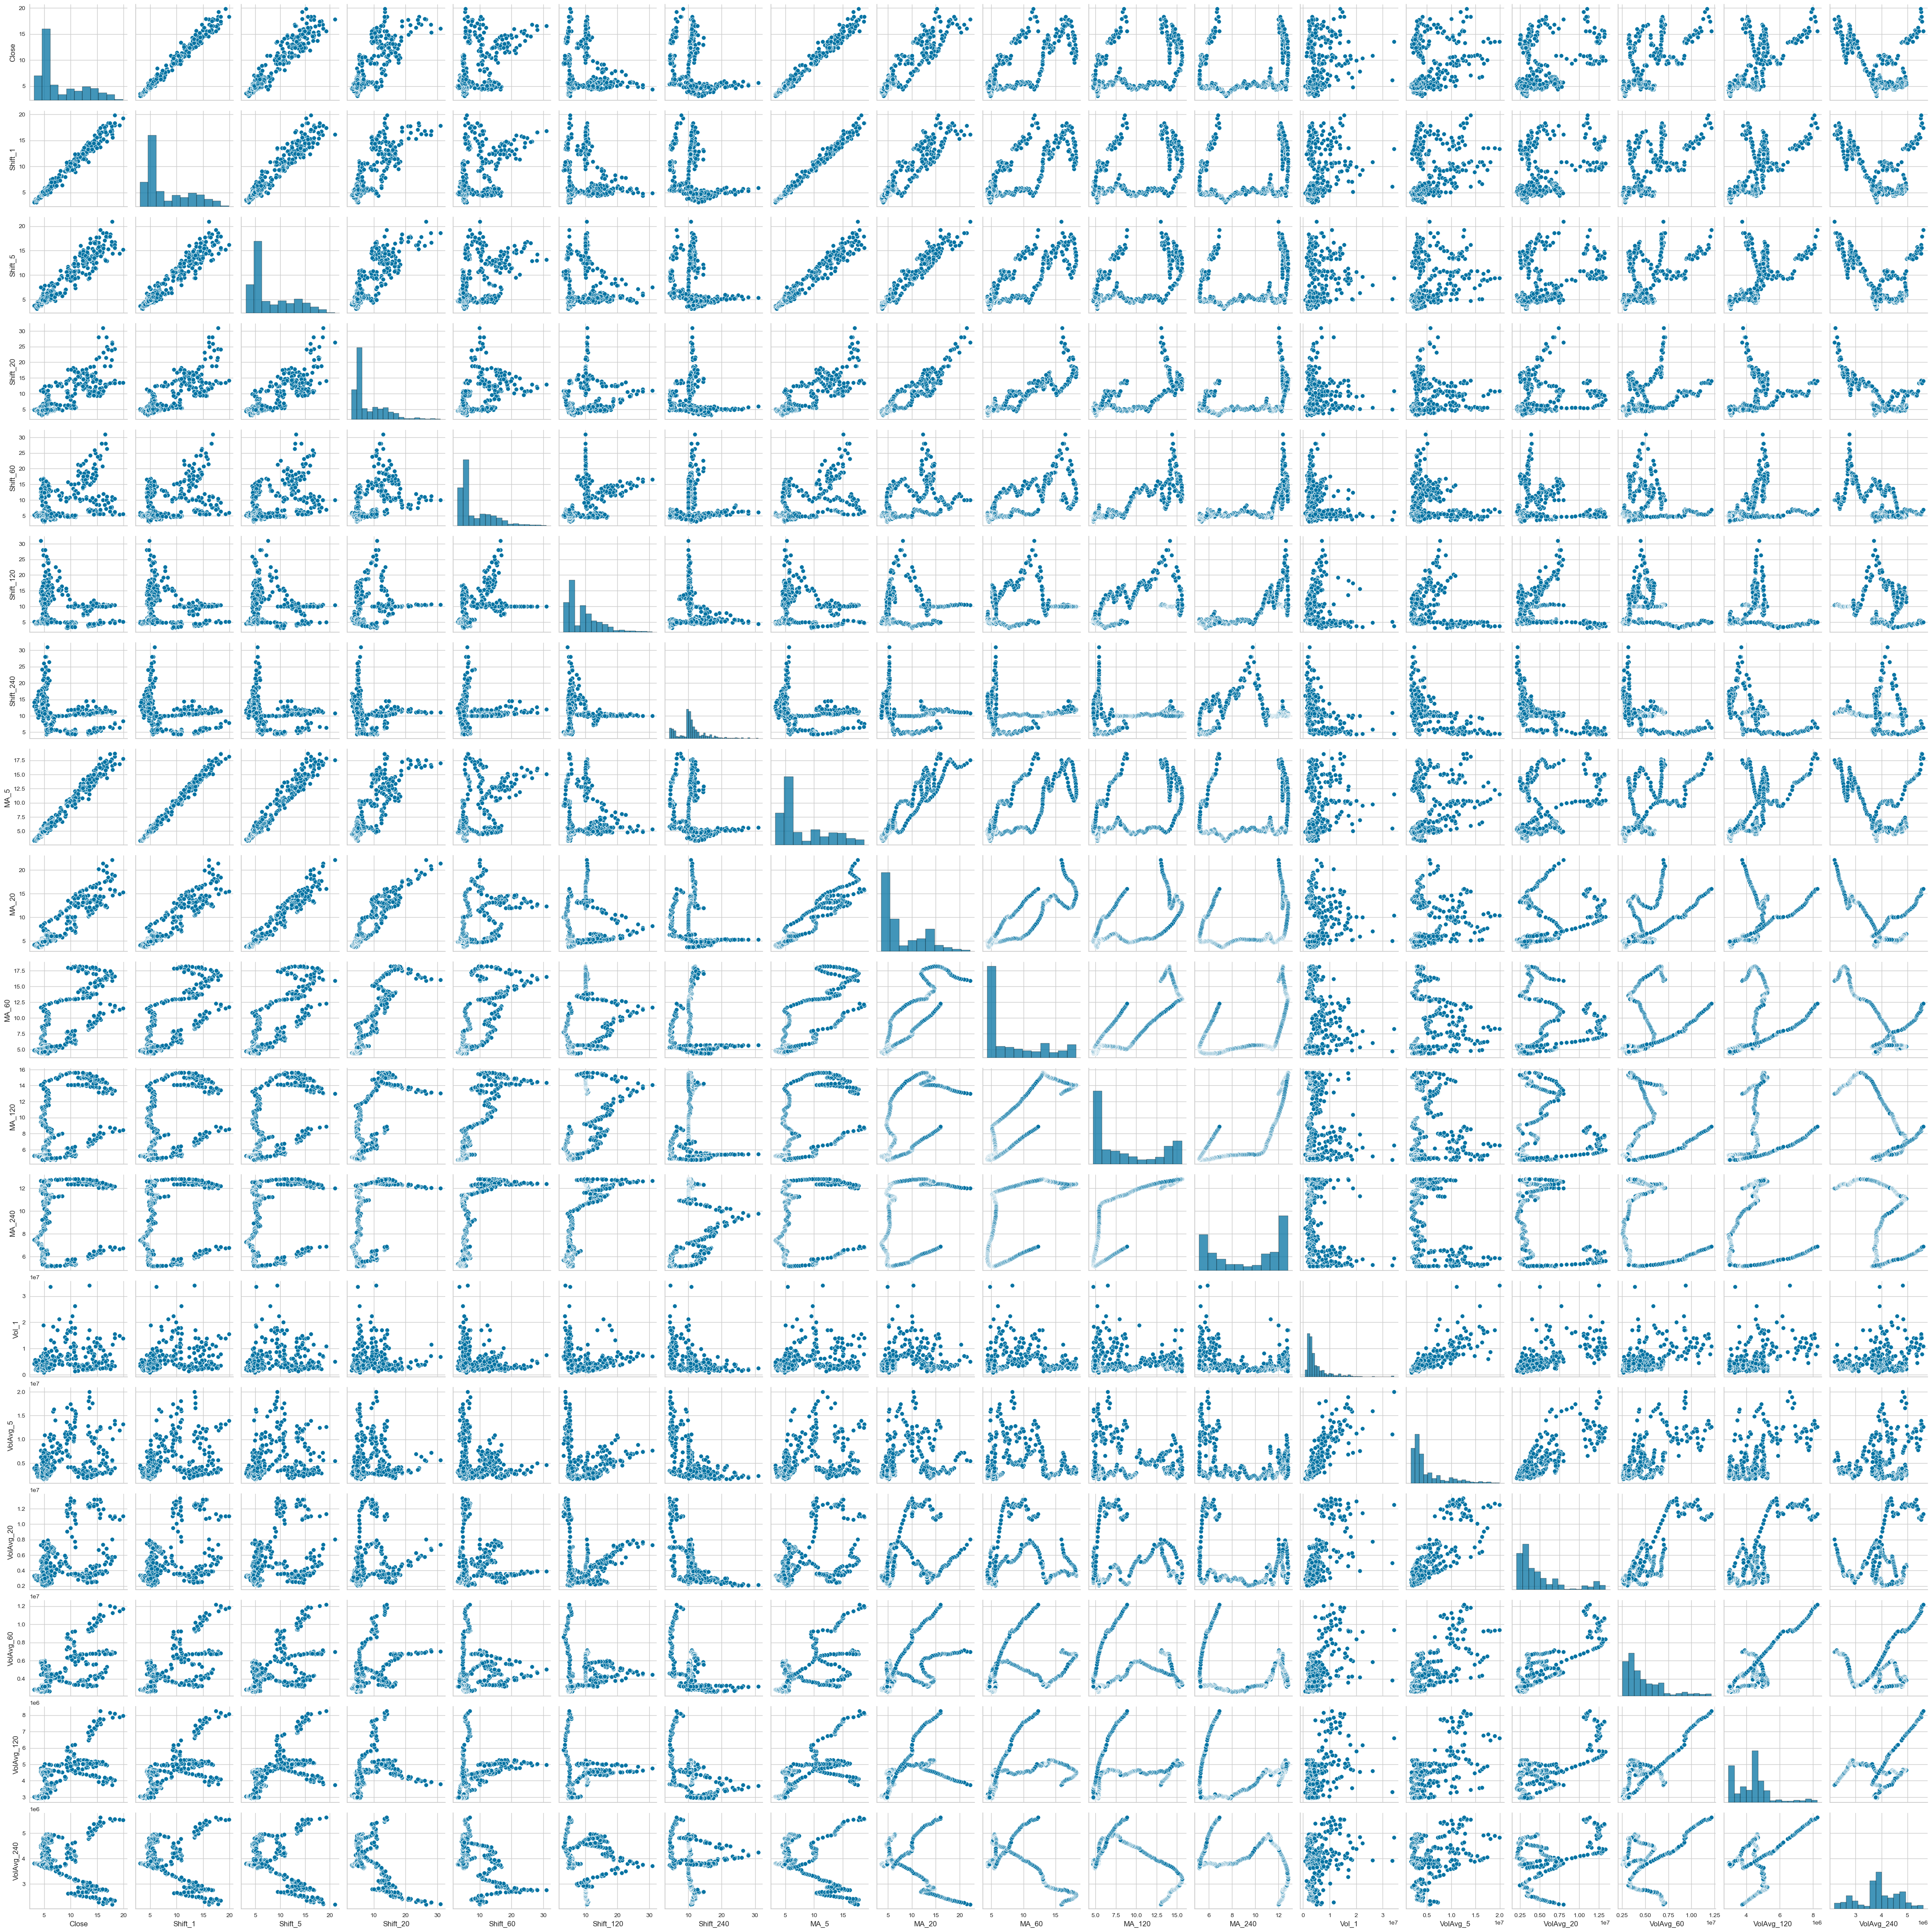

In [10]:
sns.pairplot(close)

### 4. Model Comparison

In [11]:
init_model = setup(
    session_id=123,
    data=close,
    target="Close",
    normalize=True,
    normalize_method="zscore",
    train_size=0.75,
    fold_strategy="kfold",
    fold=10
)

In [12]:
init_model.data

Shift_1    Shift_5   Shift_20  Shift_60  Shift_120  Shift_240  \
2022-07-20     4.73   4.430000   5.140000      9.18      10.71   9.980000   
2022-11-22     4.80   5.650000   5.400000      6.19       5.80  18.610001   
2023-01-09     3.77   3.450000   4.620000      5.05       4.73  10.440000   
2022-12-07     4.35   5.160000   4.960000      5.59       4.76  17.860001   
2023-03-09     5.06   4.760000   5.130000      4.48       5.76  13.950000   
...             ...        ...        ...       ...        ...        ...   
2022-07-19     4.59   4.470000   5.040000      9.50      10.44   9.960000   
2022-08-19     7.63   6.210000   4.880000      5.39      15.98  10.010000   
2021-12-23    16.82  16.059999  25.959999     10.93      10.53  11.180000   
2023-06-07     9.81  10.790000   6.380000      4.71       4.32   5.120000   
2023-03-22     4.87   4.770000   4.760000      3.37       5.07  12.300000   

                 MA_5    MA_20      MA_60     MA_120     MA_240      Vol_1  \
2022-07-20   4.672000   4.7060   5.489500   9.225583  11.644584  2264900.0   
2022-11-22   4.946000   5.3220   5.312167   5.379250   8.657541  2345600.0   
2023-01-09   3.658000   3.7270   4.660167   5.182583   7.227375  1728800.0   
2022-12-07   4.650000   5.0220   5.173666   5.349417   8.157208  3876800.0   
2023-03-09   4.958000   4.8740   4.389833   4.761333   5.722125  2135800.0   
...               ...      ...        ...        ...        ...        ...   
2022-07-19   4.534000   4.7070   5.557167   9.272166  11.664833  2542100.0   
2022-08-19   7.370000   6.1020   5.373000   7.785000  11.280125  5666600.0   
2021-12-23  16.582001  19.0555  16.490667  13.302250  12.137459  3889800.0   
2023-06-07   9.808001   9.2340   6.897333   5.647583   5.488500  8085400.0   
2023-03-22   4.732000   4.7690   4.510334   4.733833   5.418958  5128100.0   

              VolAvg_5   VolAvg_20   VolAvg_60  VolAvg_120  VolAvg_240  \
2022-07-20   2398360.0   3475875.0  5359903.50  4500601.50  4550361.00   
2022-11-22   3069540.0   2963570.0  2684260.00  3359505.00  3933758.25   
2023-01-09   2341620.0   3264285.0  2814261.75  3055213.25  3781550.00   
2022-12-07   2931180.0   3058250.0  2611726.75  3149200.75  3801550.50   
2023-03-09   2480180.0   2822620.0  3298575.00  2946159.25  3811948.75   
...                ...         ...         ...         ...         ...   
2022-07-19   2126560.0   3602615.0  5409531.50  4507886.50  4538124.00   
2022-08-19   8623600.0   4306000.0  4246200.00  4599838.50  4884680.00   
2021-12-23   5626360.0   5788870.0  6889818.50  4023591.75  2325975.75   
2023-06-07  11045540.0  12454300.0  7507061.50  5415802.50  4238649.00   
2023-03-22   2887820.0   2555350.0  3200680.00  3003741.75  3761115.75   

                Close  
2022-07-20   5.120000  
2022-11-22   4.850000  
2023-01-09   3.810000  
2022-12-07   4.350000  
2023-03-09   4.830000  
...               ...  
2022-07-19   4.730000  
2022-08-19   6.620000  
2021-12-23  17.860001  
2023-06-07   9.450000  
2023-03-22   4.650000  

[412 rows x 18 columns]

In [13]:
compare_models(n_select=10, sort="MSE")

Processing:   0%|          | 0/86 [00:00<?, ?it/s]

[BayesianRidge(),
 LinearRegression(n_jobs=-1),
 Ridge(random_state=123),
 HuberRegressor(),
 OrthogonalMatchingPursuit(),
 ExtraTreesRegressor(n_jobs=-1, random_state=123),
 LGBMRegressor(n_jobs=-1, random_state=123),
 RandomForestRegressor(n_jobs=-1, random_state=123),
 GradientBoostingRegressor(random_state=123),
 AdaBoostRegressor(random_state=123)]

### 5. Create Model

In [14]:
br_model = create_model('br')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## 5-1 Run by time - Leave One Out Cross Validation (LOOCV) 

In [15]:
ticker_data = close[list(close.columns[1:])+["Close"]]
ticker_data.head()

Shift_1    Shift_5   Shift_20  Shift_60  Shift_120  Shift_240  \
2021-12-15  16.100000  20.969999  26.379999     10.05      10.39      10.80   
2021-12-16  17.840000  18.610001  31.000000      9.99      10.49      11.11   
2021-12-17  16.059999  18.570000  27.959999     10.01      10.55      11.05   
2021-12-20  16.770000  16.670000  28.010000     11.30      10.69      11.11   
2021-12-21  15.280000  16.100000  23.180000     11.94      10.70      11.01   

              MA_5    MA_20      MA_60     MA_120     MA_240       Vol_1  \
2021-12-15  17.558  22.1605  15.928500  13.006167  12.002708   5066300.0   
2021-12-16  17.048  21.4135  16.029667  13.052583  12.023333   6809000.0   
2021-12-17  16.688  20.8540  16.142333  13.104417  12.047167   7132400.0   
2021-12-20  16.410  20.2175  16.208667  13.142667  12.064542  11570300.0   
2021-12-21  16.426  19.8675  16.279333  13.188333  12.086083   5446000.0   

             VolAvg_5  VolAvg_20     VolAvg_60    VolAvg_120    VolAvg_240  \
2021-12-15  5484760.0  8024910.0  6.950093e+06  3.746622e+06  2.182983e+06   
2021-12-16  5658380.0  7365160.0  7.011992e+06  3.801465e+06  2.212012e+06   
2021-12-17  7247060.0  6823755.0  7.136543e+06  3.895502e+06  2.259490e+06   
2021-12-20  7204800.0  6682255.0  7.012695e+06  3.937217e+06  2.281790e+06   
2021-12-21  6960700.0  6265540.0  6.910717e+06  3.967204e+06  2.297241e+06   

                Close  
2021-12-15  17.840000  
2021-12-16  16.059999  
2021-12-17  16.770000  
2021-12-20  15.280000  
2021-12-21  16.180000

In [28]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

X = ticker_data[list(ticker_data.columns)[:-1]]
y = ticker_data[["Close"]]

last_index = ticker_data.index[-1]

y_true, y_pred = [], []

for index in ticker_data.index:
    X_train = X.loc[index:last_index,:]
    X_test  = X.loc[[last_index],:]
    y_train = y.loc[index:last_index,"Close"]
    y_test  = y.loc[last_index,"Close"]

    # model
    model = linear_model.BayesianRidge()
    model.fit(X_train, y_train) 
    
    # prediction
    yhat = model.predict(X_test)
    
    # store
    y_true.append(y_test)
    y_pred.append(yhat[0])
    
# calculate accuracy
#r2 = r2_score(y_true, y_pred) -> useless in this case - but need in future
mae = mean_absolute_error(y_true, y_pred)
mse= mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_true, y_pred)

    #scores["r2"].append(r2)
    #scores["mae"].append(mae)
    #scores["mse"].append(mse)
    #scores["rmse"].append(rmse)
    #scores["mape"].append(mape)
    

In [29]:
mae, mse, rmse, mape

(1.710298322249207, 3.038368834767659, 1.7430917459410045, 0.10977524586806119)

In [30]:
size = len(list(y_true))
print(size)

412


In [41]:
for k in range(size-1,-1,-1):

411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162


In [44]:
cum_scores = {
    "mae":[],
    "mse":[],
    "rmse":[],
    "mape":[],
}

count = 0
#for j in range(size):
for k in range(size-1,-1,-1):
    count += 1
    ty_true = y_true[k:]
    ty_pred = y_pred[k:]
    
    tmae = mean_absolute_error(ty_true, ty_pred)
    tmse= mean_squared_error(ty_true, ty_pred)
    trmse = mean_squared_error(ty_true, ty_pred, squared=False)
    tmape = mean_absolute_percentage_error(ty_true, ty_pred)

    cum_scores["mae"].append(tmae)
    cum_scores["mse"].append(tmse)
    cum_scores["rmse"].append(trmse)
    cum_scores["mape"].append(tmape)

In [47]:
count

412

In [48]:
df = pd.DataFrame(cum_scores)
df.head()

mae           mse          rmse          mape
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1  9.503509e-14  1.806334e-26  1.343999e-13  6.099813e-15
2  7.045623e-12  1.462682e-22  1.209414e-11  4.522223e-13
3  1.330980e-11  3.673409e-22  1.916614e-11  8.542874e-13
4  1.772769e-11  5.444939e-22  2.333439e-11  1.137849e-12

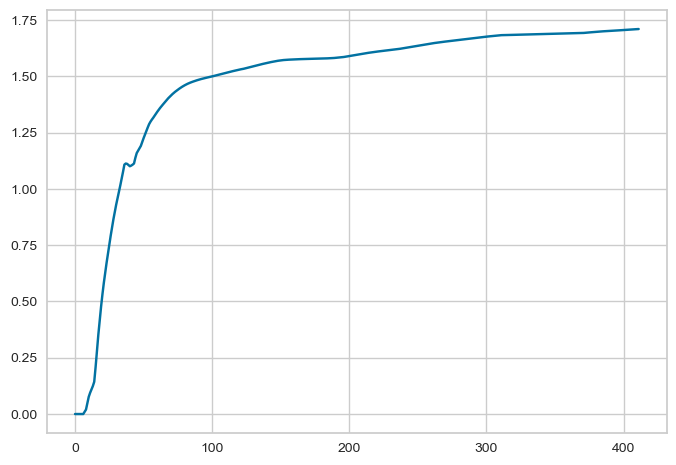

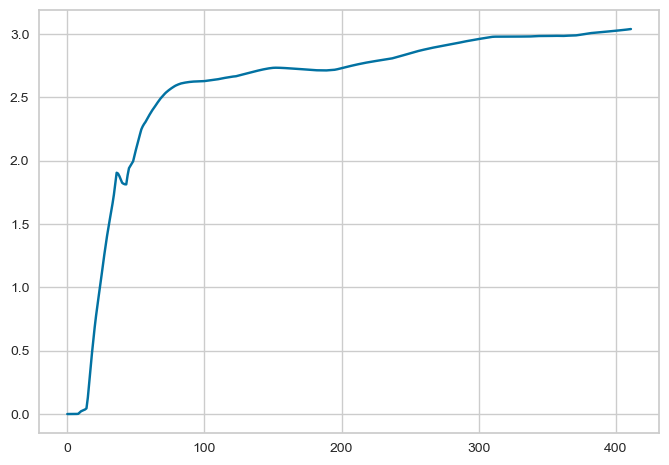

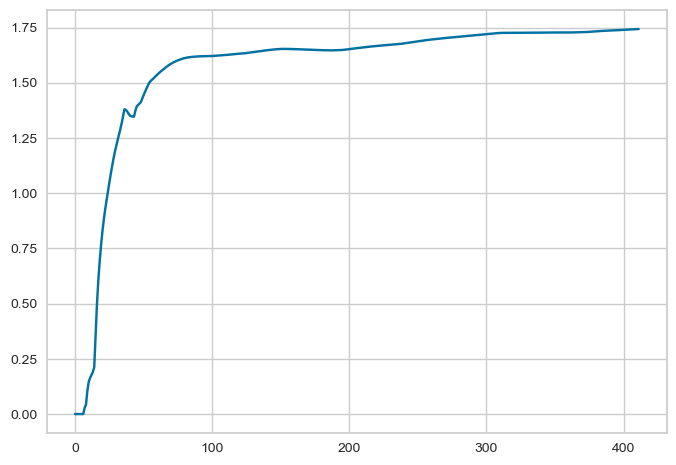

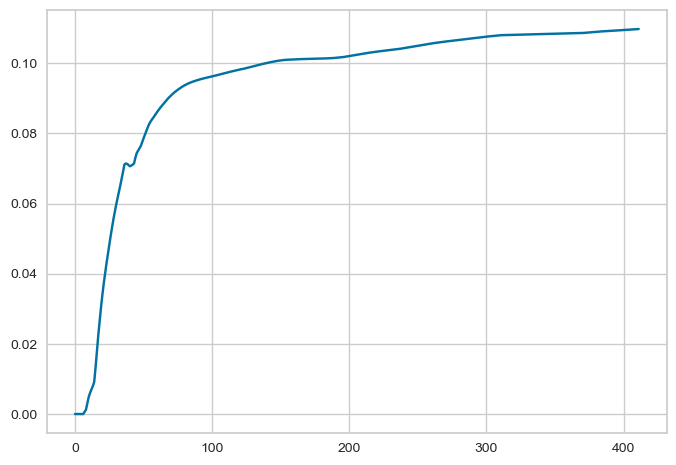

In [49]:
import matplotlib.pyplot as plt

for col in df.columns:
    df[col].plot()
    plt.show()

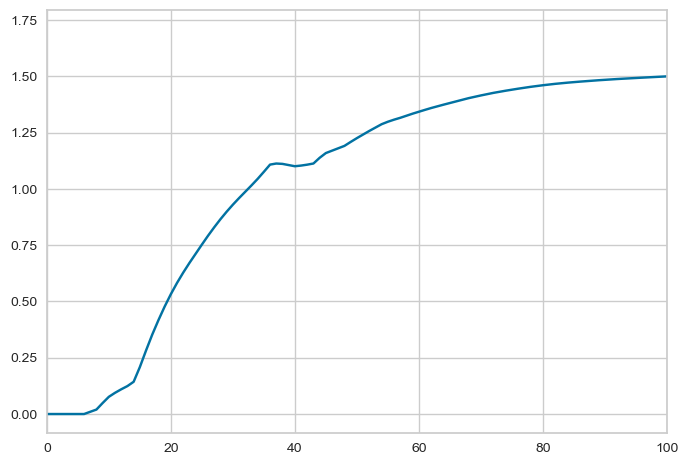

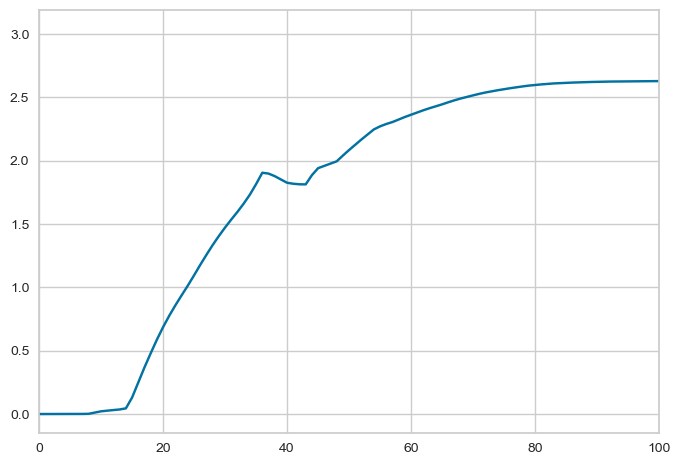

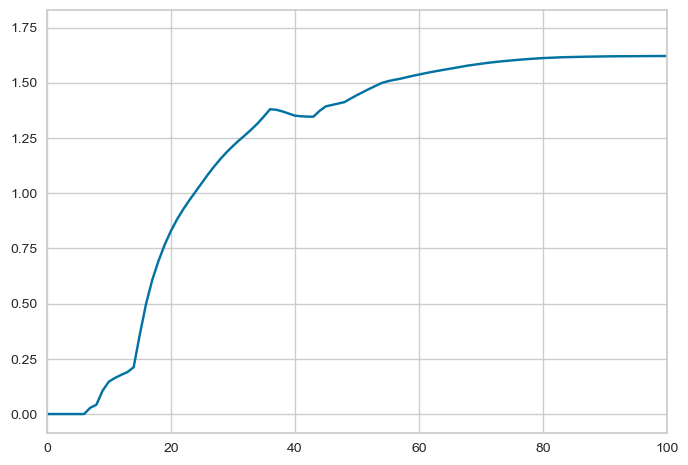

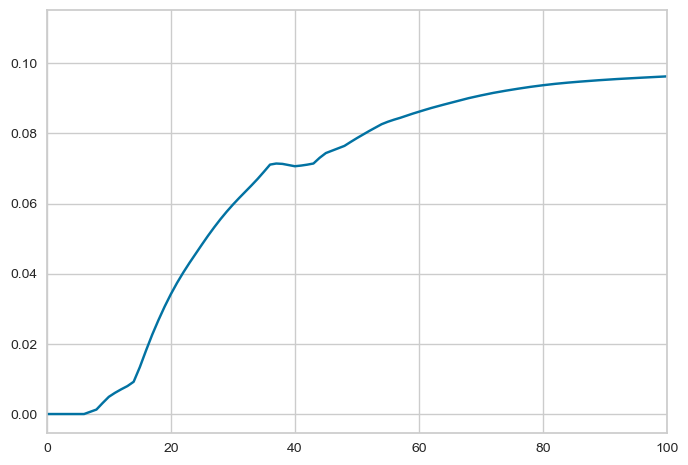

In [50]:
for col in df.columns:
    df[col].plot()
    plt.xlim([0,100])
    plt.show()

In [25]:
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# keep the index 
dindex = ticker_data.index

# x,y
X = ticker_data[list(ticker_data.columns)[:-1]]
y = ticker_data[["Close"]]

X.index = range(1,X.shape[0]+1)
y.index = range(1,X.shape[0]+1)

# create loocv procedure
LOOCV = LeaveOneOut()

# enumerate splits
y_true, y_pred = [], []

for train_ix, test_ix in LOOCV.split(X):
    X_train, X_test = X[train_ix, :], X[test_ix, :]
    y_train, y_test = y[train_ix], y[text_ix]
    
    # fit Baysian Ridge (or best performancer)
    model = linear_model.BayesianRidge()
    model.fit(X_train, y_train)
    
    yhat = model.predict(X_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])
    
# calculate accuracy
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse= mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_true, y_pred)
    


InvalidIndexError: (array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411]), slice(None, None, None))

In [28]:
test_ix

array([0])

In [23]:
X

Shift_1    Shift_5   Shift_20  Shift_60  Shift_120  Shift_240    MA_5  \
0    16.100000  20.969999  26.379999     10.05      10.39      10.80  17.558   
1    17.840000  18.610001  31.000000      9.99      10.49      11.11  17.048   
2    16.059999  18.570000  27.959999     10.01      10.55      11.05  16.688   
3    16.770000  16.670000  28.010000     11.30      10.69      11.11  16.410   
4    15.280000  16.100000  23.180000     11.94      10.70      11.01  16.426   
..         ...        ...        ...       ...        ...        ...     ...   
407  19.250000  15.220000  13.500000      5.57       5.15       8.38  17.752   
408  19.860001  16.190001  14.120000      5.90       5.13       7.86  18.180   
409  18.330000  15.530000  13.290000      6.15       4.69       7.63  18.732   
410  18.290001  17.930000  13.280000      6.38       4.81       6.62  18.624   
411  17.389999  19.250000  14.030000      6.95       4.89       6.42  17.877   

        MA_20      MA_60     MA_120     MA_240       Vol_1    VolAvg_5  \
0    22.16050  15.928500  13.006167  12.002708   5066300.0   5484760.0   
1    21.41350  16.029667  13.052583  12.023333   6809000.0   5658380.0   
2    20.85400  16.142333  13.104417  12.047167   7132400.0   7247060.0   
3    20.21750  16.208667  13.142667  12.064542  11570300.0   7204800.0   
4    19.86750  16.279333  13.188333  12.086083   5446000.0   6960700.0   
..        ...        ...        ...        ...         ...         ...   
407  15.25750  11.543167   8.460000   6.719333  13950900.0  13164720.0   
408  15.46800  11.750333   8.570000   6.762958  15524800.0  13958720.0   
409  15.71800  11.952667   8.683333   6.807375  13988200.0  13212680.0   
410  15.92350  12.136167   8.788167   6.852250   7780900.0  12415000.0   
411  15.99775  12.278917   8.876708   6.890146  10830200.0  12352716.6   

       VolAvg_20     VolAvg_60    VolAvg_120    VolAvg_240  
0     8024910.00  6.950093e+06  3.746622e+06  2.182983e+06  
1     7365160.00  7.011992e+06  3.801465e+06  2.212012e+06  
2     6823755.00  7.136543e+06  3.895502e+06  2.259490e+06  
3     6682255.00  7.012695e+06  3.937217e+06  2.281790e+06  
4     6265540.00  6.910717e+06  3.967204e+06  2.297241e+06  
..           ...           ...           ...           ...  
407  11035875.00  1.166753e+07  7.973620e+06  5.508369e+06  
408  11041425.00  1.183181e+07  8.062512e+06  5.538263e+06  
409  10921730.00  1.189428e+07  8.087948e+06  5.547073e+06  
410  11046540.00  1.201259e+07  8.155308e+06  5.569294e+06  
411  11257674.15  1.215170e+07  8.247954e+06  5.611910e+06  

[412 rows x 17 columns]

TypeError: BaseCrossValidator.split() missing 1 required positional argument: 'X'

In [50]:
train = pd.DataFrame()

df_length = ionq_data.shape[0]
point = 0

for i in range(1,(df_length//10)+1):
    
    # training df increment in stochastic manner
    if len(train) + 30 < df_length: 
        point = i*30
        
    elif point == df_length-1:
        break
    else:
        point = df_length-1
        
    train = ionq_data[:point]
    test = ionq_data.iloc[point,:]
    
    train_x = train.iloc[:,:-1]
    train_y = train.iloc[:,-1]
    
    #print(train, label)
    
    model = linear_model.BayesianRidge()
    model.fit(train_x,train_y)

              Shift_1    Shift_5   Shift_20  Shift_60  Shift_120  Shift_240  \
2021-12-15  16.100000  20.969999  26.379999     10.05      10.39      10.80   
2021-12-16  17.840000  18.610001  31.000000      9.99      10.49      11.11   
2021-12-17  16.059999  18.570000  27.959999     10.01      10.55      11.05   
2021-12-20  16.770000  16.670000  28.010000     11.30      10.69      11.11   
2021-12-21  15.280000  16.100000  23.180000     11.94      10.70      11.01   
2021-12-22  16.180000  17.840000  24.959999     11.07      10.48      11.17   
2021-12-23  16.820000  16.059999  25.959999     10.93      10.53      11.18   
2021-12-27  17.860001  16.770000  24.180000     10.40      10.44      11.20   
2021-12-28  18.299999  15.280000  24.080000      9.20      10.42      11.44   
2021-12-29  17.070000  16.180000  23.820000      7.51      10.50      11.22   
2021-12-30  17.700001  16.820000  20.750000      7.73      10.46      11.32   
2021-12-31  17.730000  17.860001  21.450001      7.2

In [37]:
ionq_data.shape

(411, 18)

'sklearn.__version__' is not recognized as an internal or external command,
operable program or batch file.
